In [1]:
import warnings
warnings.simplefilter('ignore')
import tensorflow as tf
print("Is GPU available?", tf.test.is_gpu_available())
print("TF version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available? False
TF version: 2.3.1
Keras version: 2.4.0


In [2]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [3]:
class NN(Model):
    def __init__(self, n_actions, input_shape):
        super(NN, self).__init__()
        
        self.dense1 = Dense(128, activation='relu', input_shape = (*input_shape,))
        self.dense2 = Dense(128, activation='relu')
        self.V = Dense(1, activation=None)
        self.A = Dense(n_actions, activation=None)
    
    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        V = self.V(x)
        A = self.A(x)
        
        Q = (V + (A - tf.math.reduce_mean(A, axis=1, keepdims=True)))
        
        return Q
    
    def advantage(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        A = self.A(x)
        
        return A

In [4]:
class Agent():
    def __init__(self, input_shape, n_actions, mem_size, eps, eps_min, eps_dec, gamma, q_eval_name, q_next_name, 
                 replace_freq, lr=0.0001):
        self.Q_eval = NN(n_actions, input_shape)
        self.Q_next = NN(n_actions, input_shape)
        self.Q_eval.compile(optimizer=Adam(lr=lr), loss='mse')
        self.Q_next.compile(optimizer=Adam(lr=lr), loss='mse')
        #self.Q_eval.summary()
        self.memory = deque(maxlen=mem_size)
        self.eps = eps
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.gamma = gamma
        self.replace = replace_freq
        self.action_space = [i for i in range(n_actions)]
        self.steps = 0
        self.input_shape = input_shape
        self.q_eval_name = q_eval_name
        self.q_next_name = q_next_name
    
    def store(self, state, action, reward, n_state, done):
        pack = [np.expand_dims(state, axis=0), action, reward, np.expand_dims(n_state, axis=0), done]
        self.memory.append(pack)
    
    def take_data(self, batch_size):
        pack = random.sample(self.memory, batch_size)
        states = []
        actions = []
        rewards = []
        n_states = []
        dones = []
        for i in range(batch_size):
            states.append(pack[i][0])
            actions.append(pack[i][1])
            rewards.append(pack[i][2])
            n_states.append(pack[i][3])
            dones.append(pack[i][4])
        return states, actions, rewards, n_states, dones
    
    def choose_action(self, state):
        if np.random.random() > self.eps:
            return np.argmax(self.Q_eval.advantage(state))
        return np.random.choice(self.action_space)
    
    def decay_eps(self): 
        self.eps = self.eps - self.eps_dec if self.eps > self.eps_min else self.eps_min
    
    def replace_weights(self):
        if not (self.steps % self.replace):
            self.Q_next.set_weights(self.Q_eval.get_weights())
    
    def upgrade(self, batch_size=64):
        if len(self.memory) >= 4*batch_size:
            states, actions, rewards, n_states, dones = self.take_data(batch_size)
            
            self.replace_weights()
            
            q_pred = self.Q_eval(np.array(np.reshape(states, (batch_size, *self.input_shape))))
            q_next = tf.math.reduce_max(self.Q_next(np.array(np.reshape(n_states, (batch_size, *self.input_shape)))), axis=1, keepdims=True).numpy()
            
            q_target = np.copy(q_pred)
            
            for idx, terminal in enumerate(dones):
                if terminal:
                    q_next[idx] = 0.0
                q_target[idx][actions[idx]] = rewards[idx] + self.gamma*q_next[idx]
            
            states = np.reshape(states, (batch_size, *self.input_shape))
            
            self.Q_eval.train_on_batch(np.array(states), np.array(q_target))
            
            self.decay_eps()
            self.steps += 1

    def save(self):
        self.Q_eval.save_weights(self.q_eval_name)
        

In [5]:
env = gym.make('LunarLander-v2')
n_games = 1000
agent = Agent(input_shape=env.observation_space.shape, n_actions=env.action_space.n, mem_size=10000, eps=1.0, 
              eps_min=0.001, eps_dec=0.001, gamma=0.99, q_eval_name='Q_eval.h5', q_next_name='Q_next.h5', 
              replace_freq=300)
best_score = -500
scores = []
means = []
eps = []
for i in range(n_games):
    done = False
    state = env.reset()
    score = 0
    while not done:
        action = agent.choose_action(np.expand_dims(state, axis=0))
        n_state, reward, done, _ = env.step(action)
        score += reward
        agent.store(state, action, reward, n_state, int(done))
        state = n_state
        agent.upgrade()
    scores.append(score)
    mean = np.mean(scores[-20:])
    means.append(mean)
    eps.append(agent.eps)
    if mean > best_score:
        agent.save()
        best_score = mean
    print('episode: ', i+1, '   score: ', score, '   eps:  %.3f' %agent.eps)
    if np.mean(scores[-100:]) > 270:
        print("Environment Solved!")
        agent.save()
        break
env.close()

episode:  1    score:  -330.13214727860486    eps:  1.000
episode:  2    score:  -180.23635295637948    eps:  1.000
episode:  3    score:  -361.41922465982185    eps:  0.980
episode:  4    score:  -404.2808350847654    eps:  0.893
episode:  5    score:  -119.81031634683752    eps:  0.827
episode:  6    score:  -307.09176512224894    eps:  0.753
episode:  7    score:  -165.2295664071978    eps:  0.685
episode:  8    score:  -114.11624449713119    eps:  0.613
episode:  9    score:  -103.31160997947916    eps:  0.550
episode:  10    score:  -225.4892949691356    eps:  0.455
episode:  11    score:  -632.1484492090292    eps:  0.267
episode:  12    score:  -221.28285649341706    eps:  0.184
episode:  13    score:  -403.15940440528124    eps:  0.119
episode:  14    score:  -231.0220494009908    eps:  0.034
episode:  15    score:  -364.6425911561    eps:  0.001
episode:  16    score:  -310.874242509532    eps:  0.001
episode:  17    score:  -187.72366161934258    eps:  0.001
episode:  18    s

episode:  142    score:  -5.902210353816709    eps:  0.001
episode:  143    score:  -61.24601324882079    eps:  0.001
episode:  144    score:  -14.761618812040393    eps:  0.001
episode:  145    score:  177.63955536245334    eps:  0.001
episode:  146    score:  -34.554213464140304    eps:  0.001
episode:  147    score:  -53.44924292664584    eps:  0.001
episode:  148    score:  -37.466333386647804    eps:  0.001
episode:  149    score:  130.70003490837058    eps:  0.001
episode:  150    score:  -21.77966045034032    eps:  0.001
episode:  151    score:  -44.30118747265345    eps:  0.001
episode:  152    score:  -38.71178676572224    eps:  0.001
episode:  153    score:  -37.34963617301559    eps:  0.001
episode:  154    score:  -33.044378151465104    eps:  0.001
episode:  155    score:  29.289836079490943    eps:  0.001
episode:  156    score:  -31.170661251429003    eps:  0.001
episode:  157    score:  -33.02522969988787    eps:  0.001
episode:  158    score:  -24.101877851347776    eps

episode:  282    score:  282.83746073923623    eps:  0.001
episode:  283    score:  234.0447646644426    eps:  0.001
episode:  284    score:  207.69159000436198    eps:  0.001
episode:  285    score:  241.477476844931    eps:  0.001
episode:  286    score:  218.72965353791318    eps:  0.001
episode:  287    score:  241.2056094369201    eps:  0.001
episode:  288    score:  219.3225797382347    eps:  0.001
episode:  289    score:  224.49054194191922    eps:  0.001
episode:  290    score:  234.34498075416928    eps:  0.001
episode:  291    score:  272.52756450611105    eps:  0.001
episode:  292    score:  216.76011405806753    eps:  0.001
episode:  293    score:  -145.77241467477148    eps:  0.001
episode:  294    score:  250.99137455129537    eps:  0.001
episode:  295    score:  227.60212516076717    eps:  0.001
episode:  296    score:  238.51480724135    eps:  0.001
episode:  297    score:  214.8035600140345    eps:  0.001
episode:  298    score:  260.85109597702194    eps:  0.001
episo

episode:  422    score:  248.46247657411743    eps:  0.001
episode:  423    score:  230.06777441968384    eps:  0.001
episode:  424    score:  262.68042405171576    eps:  0.001
episode:  425    score:  134.81586585395718    eps:  0.001
episode:  426    score:  257.299748816261    eps:  0.001
episode:  427    score:  259.72542008536647    eps:  0.001
episode:  428    score:  249.69967815815605    eps:  0.001
episode:  429    score:  242.48056543729362    eps:  0.001
episode:  430    score:  270.1611694449756    eps:  0.001
episode:  431    score:  213.3868916761116    eps:  0.001
episode:  432    score:  244.79742184206597    eps:  0.001
episode:  433    score:  252.0302017417456    eps:  0.001
episode:  434    score:  246.06726763986657    eps:  0.001
episode:  435    score:  236.6683538485632    eps:  0.001
episode:  436    score:  266.21546131604254    eps:  0.001
episode:  437    score:  120.88926276475047    eps:  0.001
episode:  438    score:  227.5328664606829    eps:  0.001
epis

episode:  563    score:  294.0258108130691    eps:  0.001
episode:  564    score:  267.8057935400652    eps:  0.001
episode:  565    score:  258.67992897633496    eps:  0.001
episode:  566    score:  249.4484605209956    eps:  0.001
episode:  567    score:  278.21698510534685    eps:  0.001
episode:  568    score:  263.96328412570836    eps:  0.001
episode:  569    score:  245.83135960543356    eps:  0.001
episode:  570    score:  267.1278181448479    eps:  0.001
episode:  571    score:  280.19458331792725    eps:  0.001
episode:  572    score:  287.9696034311412    eps:  0.001
episode:  573    score:  277.78008681909574    eps:  0.001
episode:  574    score:  8.667344613208002    eps:  0.001
episode:  575    score:  256.3806634115464    eps:  0.001
episode:  576    score:  33.31065247442265    eps:  0.001
episode:  577    score:  256.7760461537139    eps:  0.001
episode:  578    score:  286.3510486434437    eps:  0.001
episode:  579    score:  267.40468904124043    eps:  0.001
episode

episode:  704    score:  249.70615433188394    eps:  0.001
episode:  705    score:  267.75854682214344    eps:  0.001
episode:  706    score:  284.50995946860087    eps:  0.001
episode:  707    score:  252.04854073302764    eps:  0.001
episode:  708    score:  245.9453230599801    eps:  0.001
episode:  709    score:  239.59354369737204    eps:  0.001
episode:  710    score:  243.16551030451873    eps:  0.001
episode:  711    score:  251.78278851869226    eps:  0.001
episode:  712    score:  263.23144966527946    eps:  0.001
episode:  713    score:  260.7814533977268    eps:  0.001
episode:  714    score:  250.80792666650632    eps:  0.001
episode:  715    score:  262.5224320238733    eps:  0.001
episode:  716    score:  277.78949653118116    eps:  0.001
episode:  717    score:  279.5630553746421    eps:  0.001
episode:  718    score:  277.96383507238    eps:  0.001
episode:  719    score:  286.83658009805686    eps:  0.001
episode:  720    score:  247.34726531340542    eps:  0.001
epis

episode:  844    score:  230.27370524052543    eps:  0.001
episode:  845    score:  281.060998263134    eps:  0.001
episode:  846    score:  274.89556685012053    eps:  0.001
episode:  847    score:  305.9451427371226    eps:  0.001
episode:  848    score:  286.02104287872237    eps:  0.001
episode:  849    score:  255.32165264909517    eps:  0.001
episode:  850    score:  255.79804581503672    eps:  0.001
episode:  851    score:  300.0581829048615    eps:  0.001
episode:  852    score:  244.0087197832641    eps:  0.001
episode:  853    score:  273.2967275626295    eps:  0.001
episode:  854    score:  259.20430410500217    eps:  0.001
episode:  855    score:  295.3708893910259    eps:  0.001
episode:  856    score:  262.9683493472986    eps:  0.001
episode:  857    score:  283.6124053398605    eps:  0.001
episode:  858    score:  253.8586508124459    eps:  0.001
episode:  859    score:  265.81173017221175    eps:  0.001
episode:  860    score:  243.48486441622347    eps:  0.001
episode

episode:  985    score:  254.7600099686884    eps:  0.001
episode:  986    score:  302.8513023271629    eps:  0.001
episode:  987    score:  249.7358116064165    eps:  0.001
episode:  988    score:  252.70059478369893    eps:  0.001
episode:  989    score:  265.74538919131027    eps:  0.001
episode:  990    score:  259.3825383889687    eps:  0.001
episode:  991    score:  297.12555882768675    eps:  0.001
episode:  992    score:  285.3840348571056    eps:  0.001
episode:  993    score:  249.8530509779157    eps:  0.001
episode:  994    score:  266.8861698929411    eps:  0.001
episode:  995    score:  314.7642058680158    eps:  0.001
episode:  996    score:  257.9266494215167    eps:  0.001
episode:  997    score:  285.61567554867753    eps:  0.001
episode:  998    score:  274.4733367758431    eps:  0.001
episode:  999    score:  243.15281102412555    eps:  0.001
episode:  1000    score:  273.7858571719788    eps:  0.001


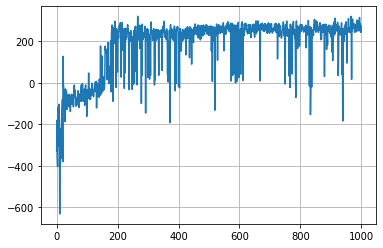

In [6]:
plt.plot(scores)
plt.grid()
plt.show()

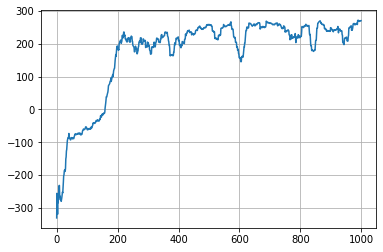

In [7]:
plt.plot(means)
plt.grid()
plt.show()

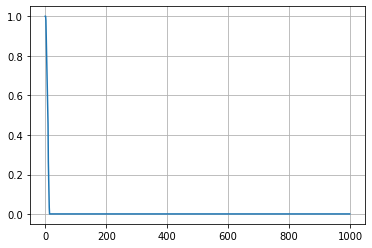

In [8]:
plt.plot(eps)
plt.grid()
plt.show()

In [9]:
env = gym.make('LunarLander-v2')
for i in range(20):
    done = False
    state = env.reset()
    while not done:
        env.render()
        action = np.argmax(agent.Q_eval.advantage(np.expand_dims(state, axis=0))[0])
        n_state, reward, done, _ = env.step(action)
        state = n_state
env.close()